# Eliminar cache

In [1]:
import torch
torch.cuda.empty_cache()

# U-Net

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as T
from PIL import Image
import time
from torchvision.transforms import functional as TF
import random

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Codificador
        self.encoder1 = self._block(in_channels, 32)
        self.encoder2 = self._block(32, 64)
        self.encoder3 = self._block(64, 128)
        self.encoder4 = self._block(128, 256)
        self.encoder5 = self._block(256, 512)
        self.encoder6 = self._block(512, 1024)
        self.encoder7 = self._block(1024, 2048)

        # Decodificador
        self.upconv7 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder7 = self._block(2048, 1024)
        self.upconv6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder6 = self._block(1024, 512)
        self.upconv5 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder5 = self._block(512, 256)
        self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder4 = self._block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = self._block(128, 64)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder2 = self._block(64, 32)
        self.decoder1 = self._block(32, 32, out_channels=out_channels, final_layer=True)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _block(self, in_channels, features, out_channels=None, final_layer=False): 
        layers = [
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        ]
        if final_layer:
            layers.append(nn.Conv2d(features, out_channels, kernel_size=1))  
            layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))
        enc6 = self.encoder6(self.pool(enc5))
        enc7 = self.encoder7(self.pool(enc6))

        dec7 = self.upconv7(enc7)
        dec7 = torch.cat((dec7, enc6), dim=1)
        dec7 = self.decoder7(dec7)
        dec6 = self.upconv6(dec7)
        dec6 = torch.cat((dec6, enc5), dim=1)
        dec6 = self.decoder6(dec6)
        dec5 = self.upconv5(dec6)
        dec5 = torch.cat((dec5, enc4), dim=1)
        dec5 = self.decoder5(dec5)
        dec4 = self.upconv4(dec5)
        dec4 = torch.cat((dec4, enc3), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc1), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.decoder1(dec2)
        return dec1

# Crear el dataset y los loaders
image_folder = r'C:\tesis\Imagenes Kaggle\all_images\converted_images_16bits'
mask_folder = r'C:\tesis\transformadas\mascaras'

# Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder, augment=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augment = augment
        self.images = os.listdir(image_folder)
        self.masks = os.listdir(mask_folder)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.images[idx])
        mask_name = os.path.join(self.mask_folder, self.masks[idx])

        # Cargar imagen y máscara
        image = Image.open(img_name).convert('I;16')
        mask = Image.open(mask_name).convert('L')

        # Normalizar intensidades
        image = np.array(image).astype(np.float32) / 65536.0  
        mask = np.array(mask).astype(np.float32) / 255.0

        if self.augment:
            seed = random.randint(0, 10000)
            random.seed(seed)
            torch.manual_seed(seed)

            # Volteos
            if random.random() > 0.5:
                image = np.fliplr(image).copy()
                mask = np.fliplr(mask).copy()

            if random.random() > 0.5:
                image = np.flipud(image).copy()
                mask = np.flipud(mask).copy()

            # Rotación moderada (-10° a 10°)
            angle = random.uniform(-10, 10)
            image = TF.rotate(Image.fromarray((image * 255).astype(np.uint8)), angle)
            mask = TF.rotate(Image.fromarray((mask * 255).astype(np.uint8)), angle)

            # Recorte aleatorio con redimensionado
            crop_transform = T.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0))
            image = crop_transform(Image.fromarray((image * 255).astype(np.uint8)))
            mask = crop_transform(Image.fromarray((mask * 255).astype(np.uint8)))

            # Convertir a numpy después de transformaciones
            image = np.array(image).astype(np.float32) / 255.0
            mask = np.array(mask).astype(np.float32) / 255.0

        # Convertir a tensores
        image = torch.tensor(image).unsqueeze(0)
        mask = torch.tensor(mask).unsqueeze(0)

        return image, mask
    
# Función para calcular precisión
def calculate_precision(predictions, masks):
    binary_predictions = (predictions > 0.5).float()
    TP = ((binary_predictions == 1) & (masks == 1)).float().sum()
    FP = ((binary_predictions == 1) & (masks == 0)).float().sum()
    precision = TP / (TP + FP + 1e-8)
    return precision.item()

# Función para calcular exactitud (accuracy)
def calculate_accuracy(predictions, masks):
    binary_predictions = (predictions > 0.5).float()
    correct = (binary_predictions == masks).float().sum()
    total = masks.numel()
    accuracy = correct / total
    return accuracy.item()

# Crear los datasets
train_dataset = CustomDataset(
    image_folder=image_folder,
    mask_folder=mask_folder,
    augment=True  
)

val_dataset = CustomDataset(
    image_folder=image_folder,
    mask_folder=mask_folder,
    augment=False 
)

test_dataset = CustomDataset(
    image_folder=image_folder,
    mask_folder=mask_folder,
    augment=False 
)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Val_dec ({self.val_loss_min:.3f} --> {val_loss:.3f}). Guardando...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


# Función de pérdida ponderada
pos_weight=5
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        weights = targets * self.pos_weight + (1 - targets) * 1
        bce = F.binary_cross_entropy_with_logits(outputs, targets, reduction='none')
        weighted_bce = weights * bce
        return weighted_bce.mean()


# Inicializar el modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = WeightedBCELoss(pos_weight=pos_weight)  # Ajusta este valor como sea necesario
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Crear el dataset
custom_dataset = CustomDataset(image_folder=image_folder, mask_folder=mask_folder)

# Calcular tamaños
dataset_size = len(custom_dataset)
train_size = int(0.75 * dataset_size)
test_size = int(0.15 * dataset_size)
val_size = dataset_size - train_size - test_size  

# Dividir los datasets
train_dataset, test_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False)


# Early Stopping
early_stopping = EarlyStopping(patience=15, verbose=True)

# Entrenamiento
num_epochs = 600
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    total_train_loss = 0.0
    total_train_accuracy = 0.0
    total_train_precision = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        accuracy = calculate_accuracy(outputs, masks)
        precision = calculate_precision(outputs, masks)
        total_train_loss += loss.item()
        total_train_accuracy += accuracy
        total_train_precision += precision

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    avg_train_precision = total_train_precision / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    total_val_accuracy = 0.0
    total_val_precision = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)

            val_accuracy = calculate_accuracy(val_outputs, val_masks)
            val_precision = calculate_precision(val_outputs, val_masks)
            total_val_loss += val_loss.item()
            total_val_accuracy += val_accuracy
            total_val_precision += val_precision

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    avg_val_precision = total_val_precision / len(val_loader)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Loss: {avg_train_loss:.4f}, Prec: {avg_train_precision:.4f}, Acc: {avg_train_accuracy:.4f}, '
          f'Val_Loss: {avg_val_loss:.4f}, Val_Prec: {avg_val_precision:.4f}, Val_Acc: {avg_val_accuracy:.4f}, '
          f'Time: {epoch_time:.2f} sec')

    # Early Stopping
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Cargar el mejor modelo
model.load_state_dict(torch.load('checkpoint.pt'))


Epoch [1/600], Loss: 0.8907, Prec: 0.2098, Acc: 0.9589, Val_Loss: 0.8542, Val_Prec: 0.7703, Val_Acc: 0.9939, Time: 17.58 sec
Val_dec (inf --> 0.854). Guardando...
Epoch [2/600], Loss: 0.8504, Prec: 0.4732, Acc: 0.9921, Val_Loss: 0.8409, Val_Prec: 0.8333, Val_Acc: 0.9948, Time: 17.14 sec
Val_dec (0.854 --> 0.841). Guardando...
Epoch [3/600], Loss: 0.8360, Prec: 0.5119, Acc: 0.9929, Val_Loss: 0.8289, Val_Prec: 0.7242, Val_Acc: 0.9942, Time: 17.14 sec
Val_dec (0.841 --> 0.829). Guardando...
Epoch [4/600], Loss: 0.8234, Prec: 0.5318, Acc: 0.9930, Val_Loss: 0.8178, Val_Prec: 0.7893, Val_Acc: 0.9946, Time: 17.18 sec
Val_dec (0.829 --> 0.818). Guardando...
Epoch [5/600], Loss: 0.8118, Prec: 0.5528, Acc: 0.9933, Val_Loss: 0.8076, Val_Prec: 0.5997, Val_Acc: 0.9920, Time: 17.19 sec
Val_dec (0.818 --> 0.808). Guardando...
Epoch [6/600], Loss: 0.8016, Prec: 0.5152, Acc: 0.9930, Val_Loss: 0.7959, Val_Prec: 0.8411, Val_Acc: 0.9950, Time: 17.19 sec
Val_dec (0.808 --> 0.796). Guardando...
Epoch [7/600

Epoch [52/600], Loss: 0.7044, Prec: 0.7118, Acc: 0.9953, Val_Loss: 0.7050, Val_Prec: 0.8017, Val_Acc: 0.9954, Time: 17.28 sec
Counter: 1 out of 15
Epoch [53/600], Loss: 0.7044, Prec: 0.7201, Acc: 0.9954, Val_Loss: 0.7040, Val_Prec: 0.8090, Val_Acc: 0.9953, Time: 17.26 sec
Val_dec (0.704 --> 0.704). Guardando...
Epoch [54/600], Loss: 0.7045, Prec: 0.6845, Acc: 0.9950, Val_Loss: 0.7056, Val_Prec: 0.8909, Val_Acc: 0.9952, Time: 17.27 sec
Counter: 1 out of 15
Epoch [55/600], Loss: 0.7042, Prec: 0.7203, Acc: 0.9953, Val_Loss: 0.7038, Val_Prec: 0.8119, Val_Acc: 0.9953, Time: 17.29 sec
Val_dec (0.704 --> 0.704). Guardando...
Epoch [56/600], Loss: 0.7037, Prec: 0.7352, Acc: 0.9956, Val_Loss: 0.7043, Val_Prec: 0.8680, Val_Acc: 0.9955, Time: 17.28 sec
Counter: 1 out of 15
Epoch [57/600], Loss: 0.7036, Prec: 0.7429, Acc: 0.9956, Val_Loss: 0.7041, Val_Prec: 0.8272, Val_Acc: 0.9947, Time: 17.27 sec
Counter: 2 out of 15
Epoch [58/600], Loss: 0.7036, Prec: 0.7437, Acc: 0.9955, Val_Loss: 0.7041, Val_P

Epoch [106/600], Loss: 0.7012, Prec: 0.8432, Acc: 0.9965, Val_Loss: 0.7034, Val_Prec: 0.9034, Val_Acc: 0.9954, Time: 17.28 sec
Counter: 9 out of 15
Epoch [107/600], Loss: 0.7014, Prec: 0.8162, Acc: 0.9962, Val_Loss: 0.7045, Val_Prec: 0.9091, Val_Acc: 0.9950, Time: 17.28 sec
Counter: 10 out of 15
Epoch [108/600], Loss: 0.7013, Prec: 0.8272, Acc: 0.9964, Val_Loss: 0.7020, Val_Prec: 0.8601, Val_Acc: 0.9956, Time: 17.26 sec
Counter: 11 out of 15
Epoch [109/600], Loss: 0.7012, Prec: 0.8603, Acc: 0.9965, Val_Loss: 0.7021, Val_Prec: 0.8941, Val_Acc: 0.9959, Time: 17.29 sec
Counter: 12 out of 15
Epoch [110/600], Loss: 0.7014, Prec: 0.7850, Acc: 0.9962, Val_Loss: 0.7013, Val_Prec: 0.8219, Val_Acc: 0.9959, Time: 17.28 sec
Val_dec (0.702 --> 0.701). Guardando...
Epoch [111/600], Loss: 0.7014, Prec: 0.8171, Acc: 0.9962, Val_Loss: 0.7031, Val_Prec: 0.8692, Val_Acc: 0.9951, Time: 17.32 sec
Counter: 1 out of 15
Epoch [112/600], Loss: 0.7015, Prec: 0.7921, Acc: 0.9961, Val_Loss: 0.7030, Val_Prec: 0.90

<All keys matched successfully>

# Metricas en train, test y val

In [4]:
import pandas as pd
import torch

def calculate_sensitivity(TP, FN):
    return TP / (TP + FN + 1e-8)

def calculate_specificity(TN, FP):
    return TN / (TN + FP + 1e-8)

def calculate_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-8)

def calculate_accuracy(TP, TN, total):
    return (TP + TN) / total

def calculate_confusion_matrix(predictions, masks, threshold=0.4):
    binary_predictions = (predictions > threshold).float()
    TP = ((binary_predictions == 1) & (masks == 1)).float().sum().item()
    FP = ((binary_predictions == 1) & (masks == 0)).float().sum().item()
    TN = ((binary_predictions == 0) & (masks == 0)).float().sum().item()
    FN = ((binary_predictions == 0) & (masks == 1)).float().sum().item()
    return TP, FP, TN, FN

def calculate_precision(TP, FP):
    return TP / (TP + FP + 1e-8)

def evaluate_metrics(loader, model):
    model.eval()
    total_TP, total_FP, total_TN, total_FN = 0, 0, 0, 0
    total_pixels = 0  # Total de píxeles procesados

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            TP, FP, TN, FN = calculate_confusion_matrix(outputs, masks)
            total_TP += TP
            total_FP += FP
            total_TN += TN
            total_FN += FN
            total_pixels += masks.numel()

    precision = calculate_precision(total_TP, total_FP)
    recall = calculate_sensitivity(total_TP, total_FN)
    specificity = calculate_specificity(total_TN, total_FP)
    accuracy = calculate_accuracy(total_TP, total_TN, total_pixels)
    f1_score = calculate_f1_score(precision, recall)

    return precision, recall, specificity, accuracy, f1_score

def display_metrics_table(train_metrics, val_metrics, test_metrics):
    metrics = {
        "Set": ["Train", "Validation", "Test"],
        "Precision": [train_metrics[0], val_metrics[0], test_metrics[0]],
        "Sensitivity": [train_metrics[1], val_metrics[1], test_metrics[1]],
        "Specificity": [train_metrics[2], val_metrics[2], test_metrics[2]],
        "Accuracy": [train_metrics[3], val_metrics[3], test_metrics[3]],
        "F1-Score": [train_metrics[4], val_metrics[4], test_metrics[4]],
    }
    df = pd.DataFrame(metrics)
    print(df)

# Evaluación
train_metrics = evaluate_metrics(train_loader, model)
val_metrics = evaluate_metrics(val_loader, model)
test_metrics = evaluate_metrics(test_loader, model)

display_metrics_table(train_metrics, val_metrics, test_metrics)


          Set  Precision  Sensitivity  Specificity  Accuracy  F1-Score
0       Train   0.791057     0.884022     0.998894  0.995682  0.834959
1  Validation   0.739225     0.862374     0.998726  0.995837  0.796065
2        Test   0.644223     0.794170     0.997561  0.993195  0.711381


# Visualizar y guardar predicciones

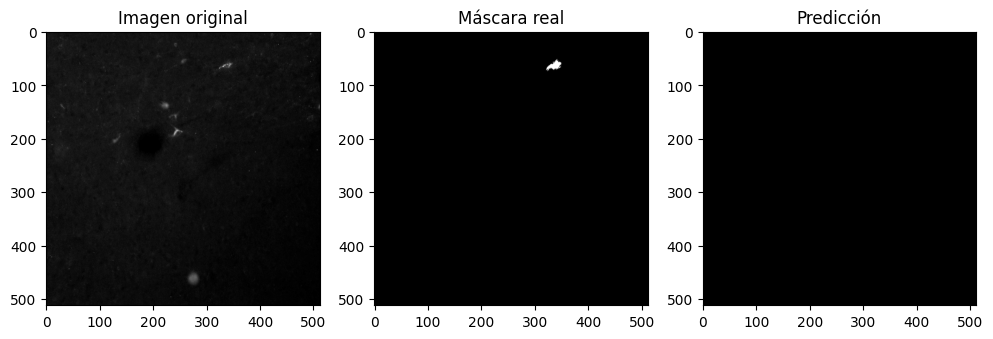

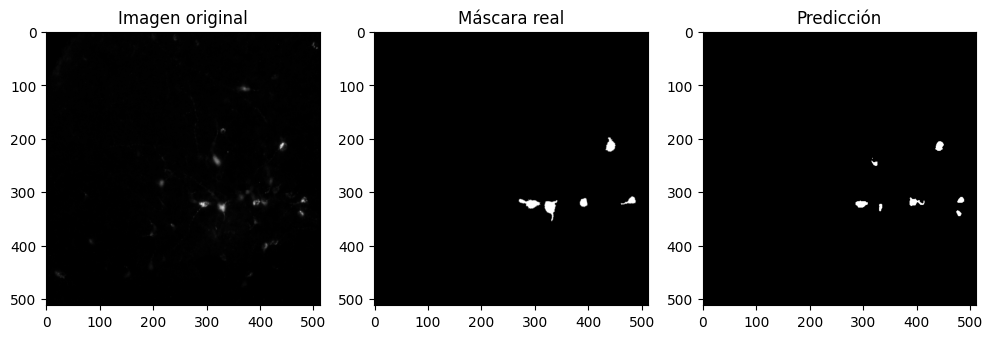

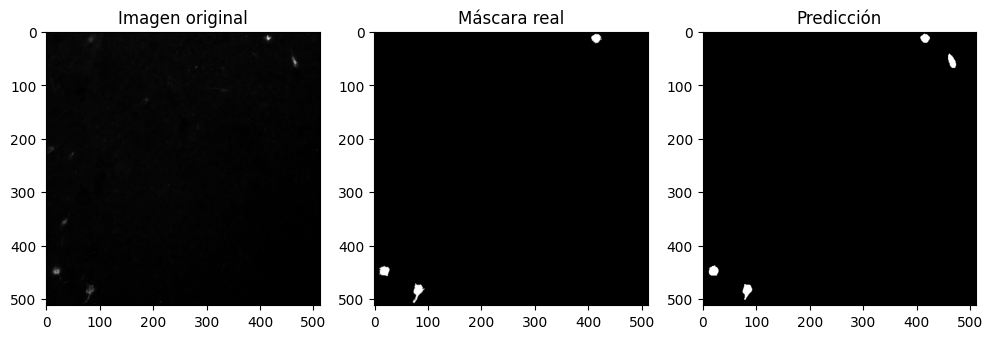

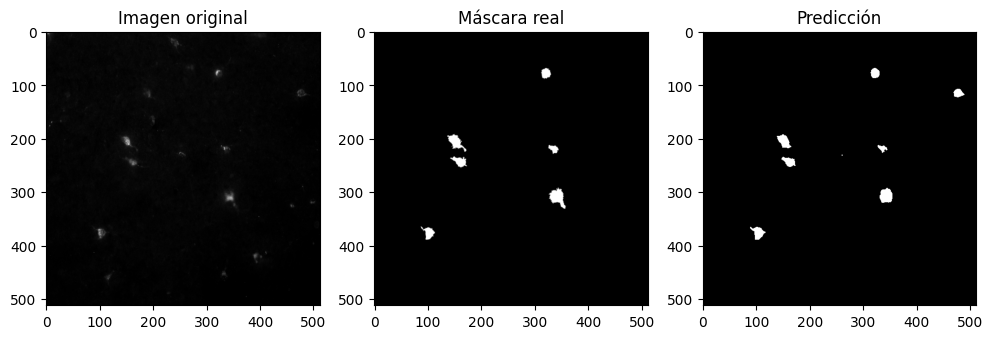

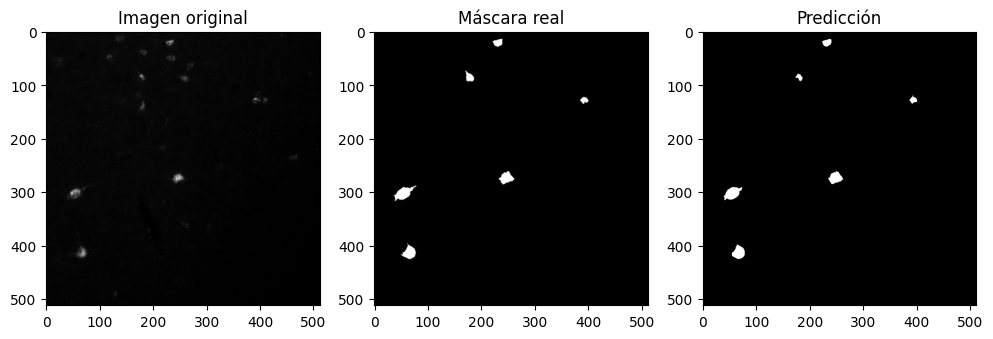

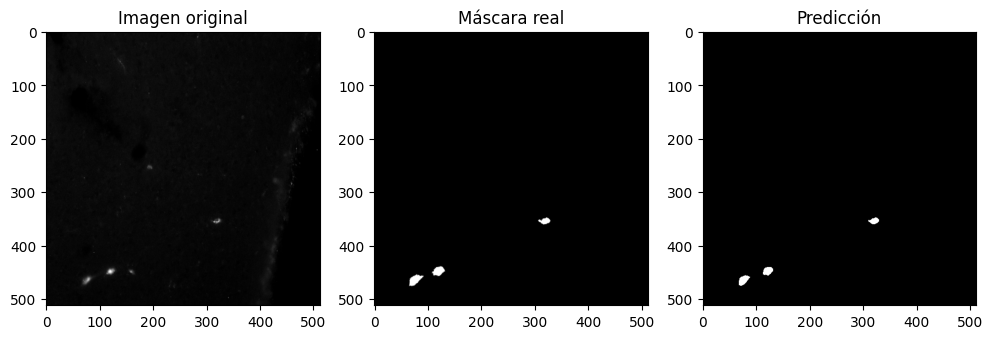

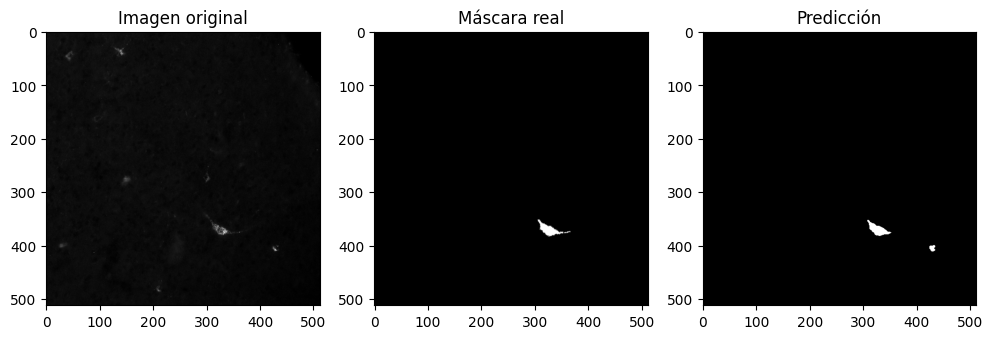

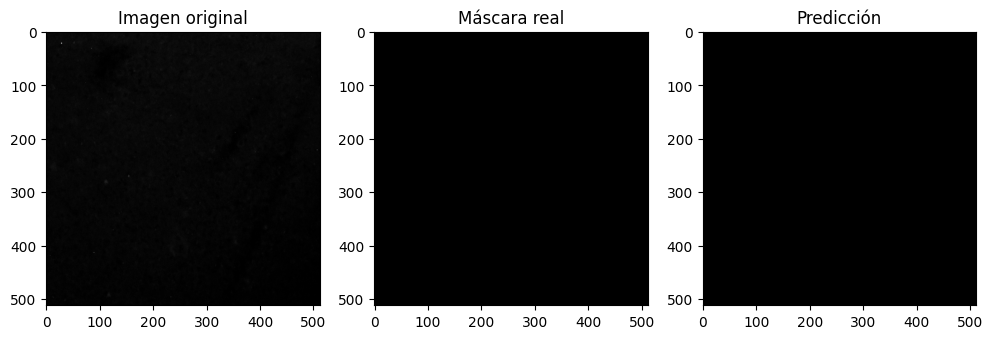

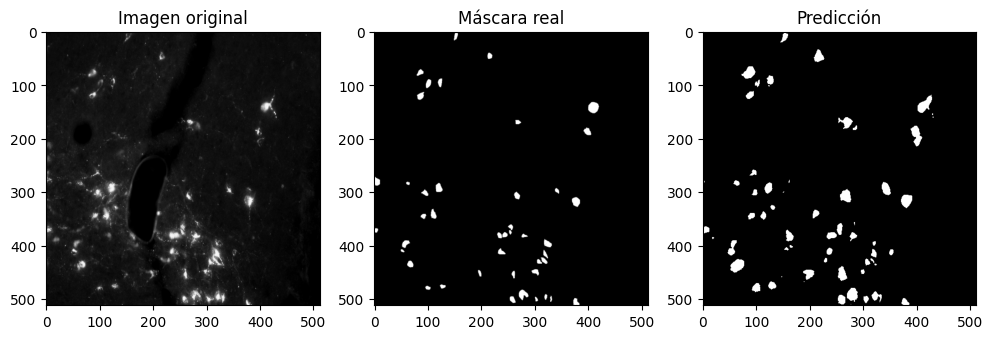

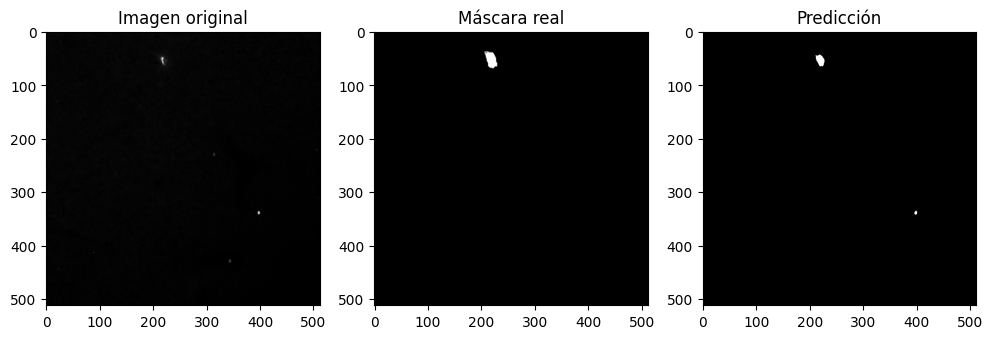

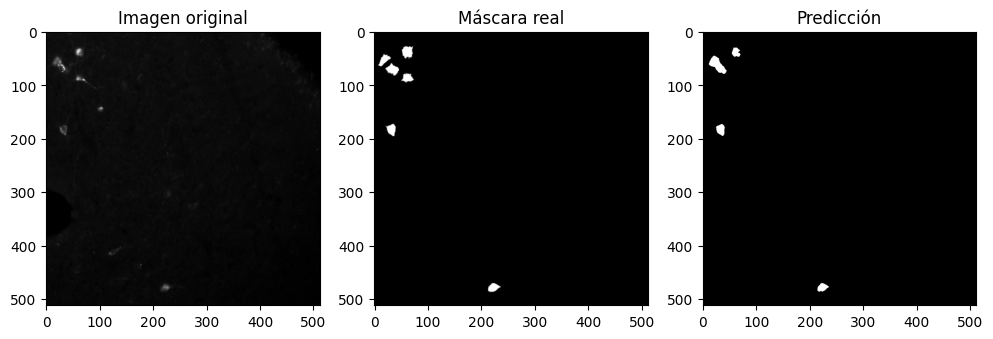

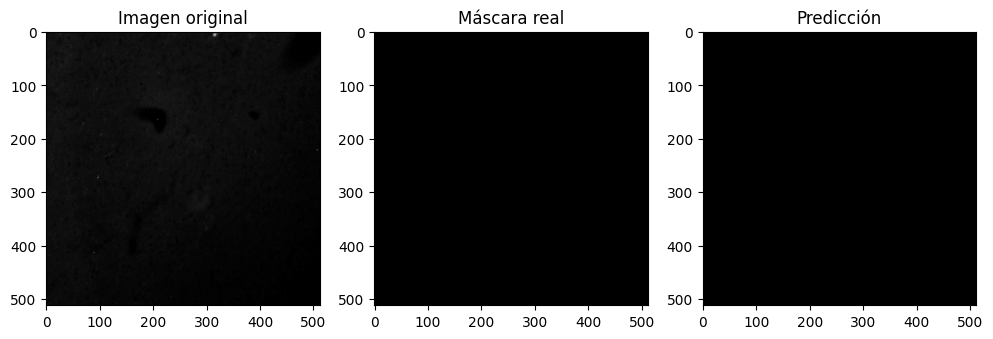

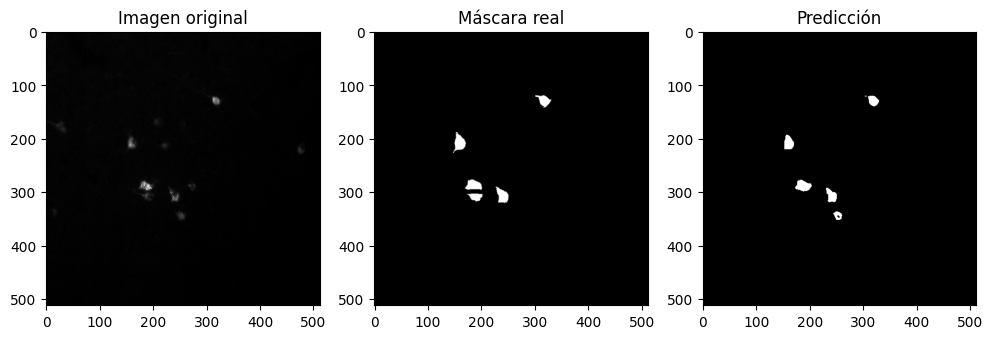

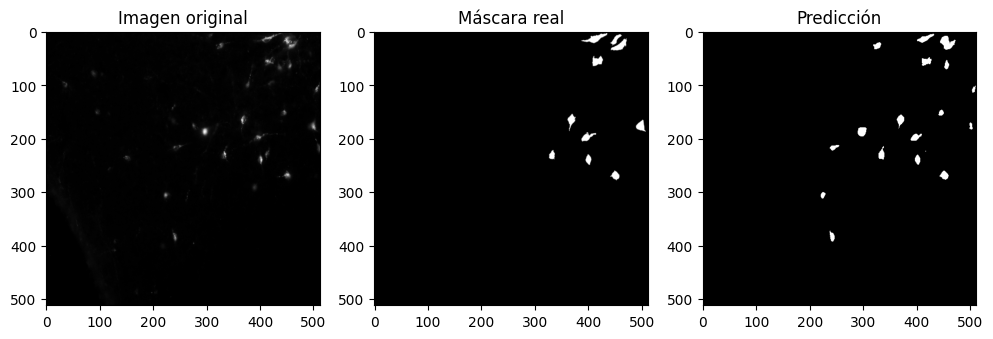

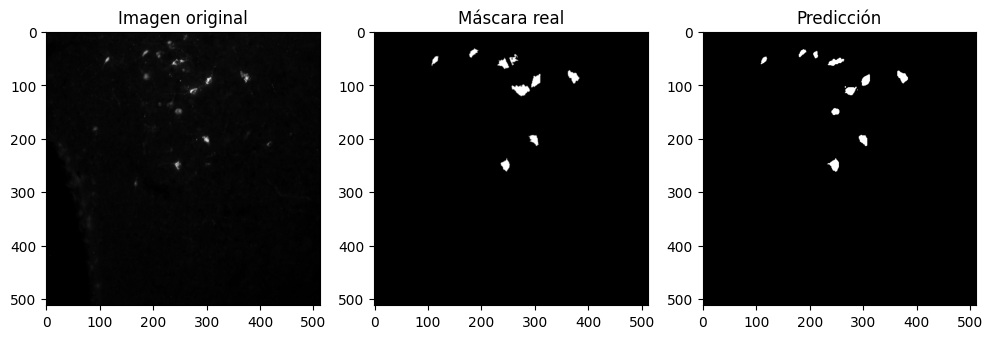

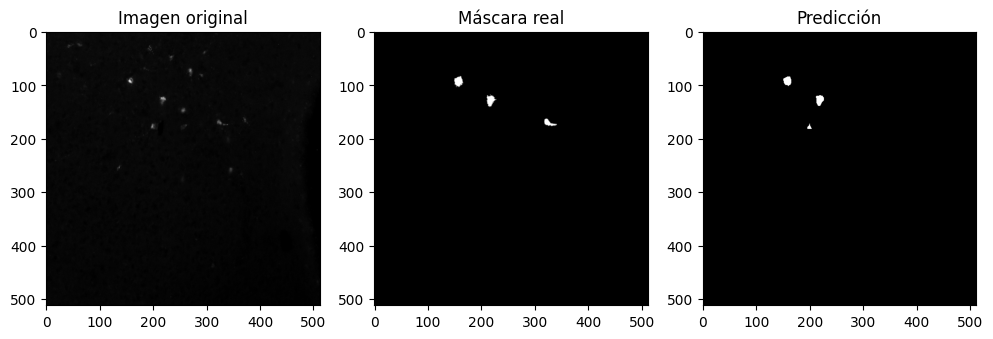

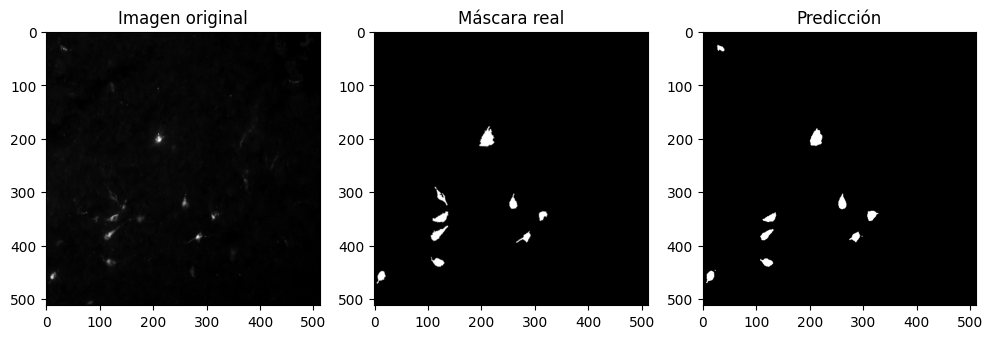

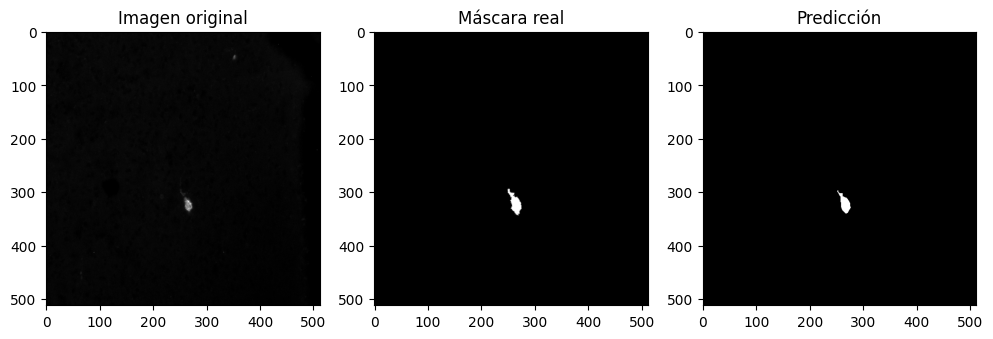

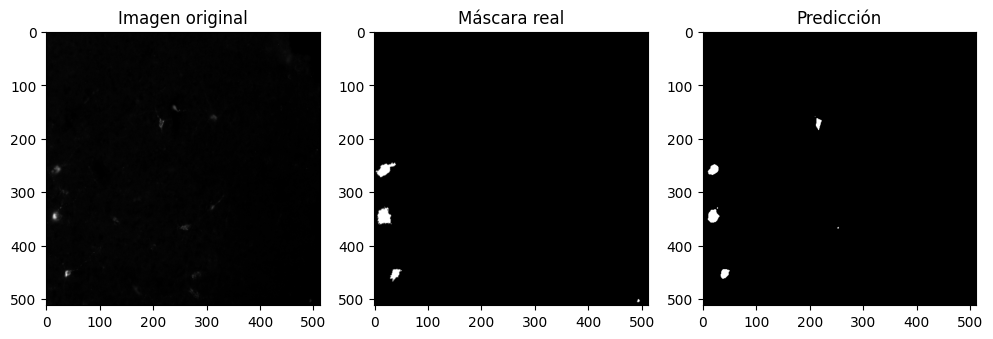

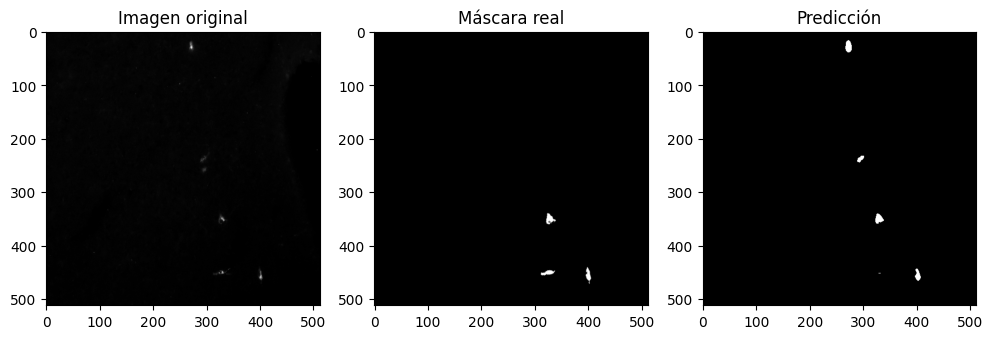

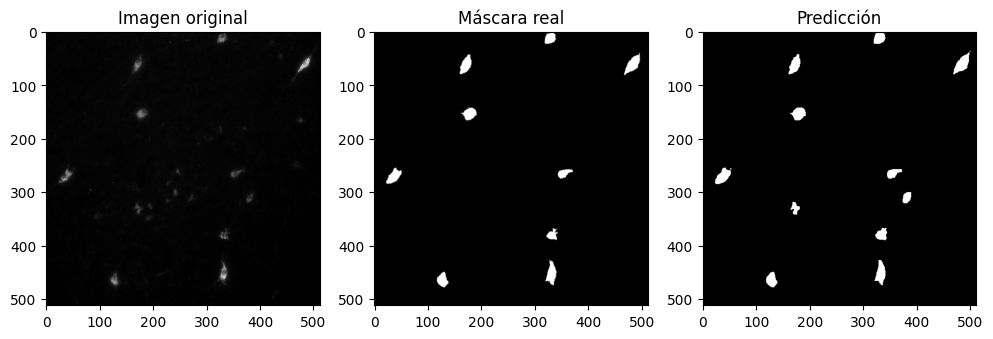

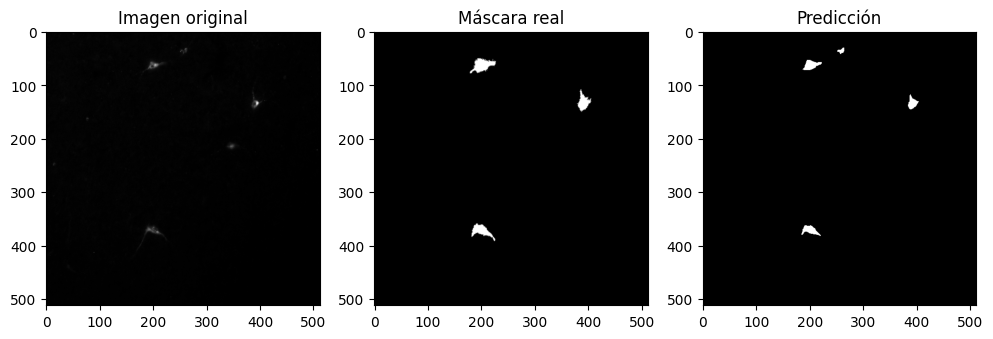

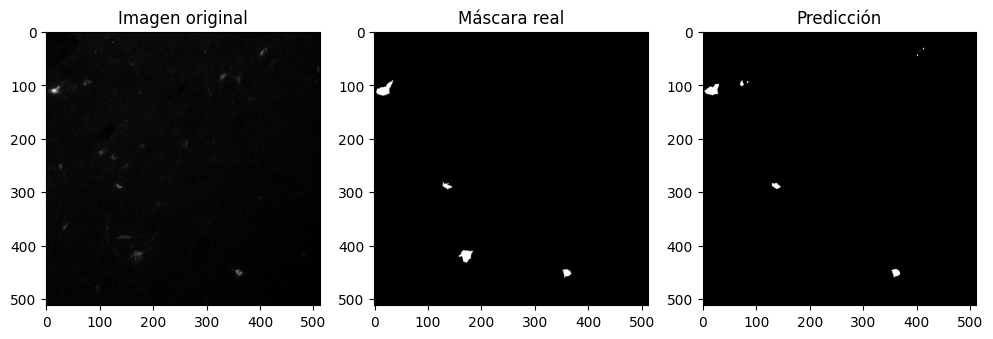

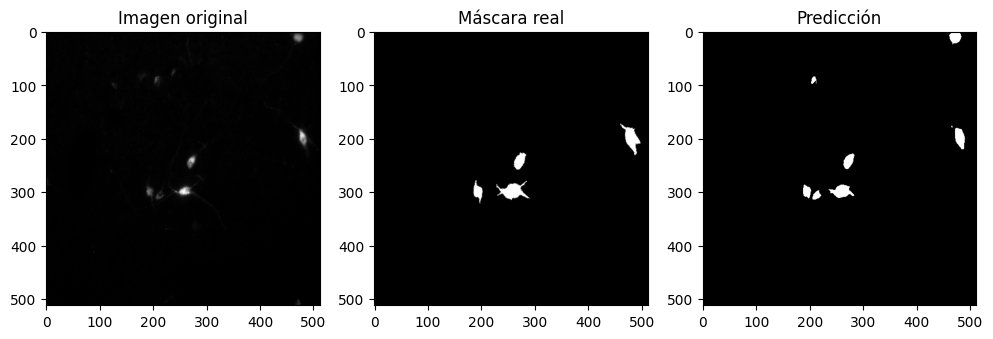

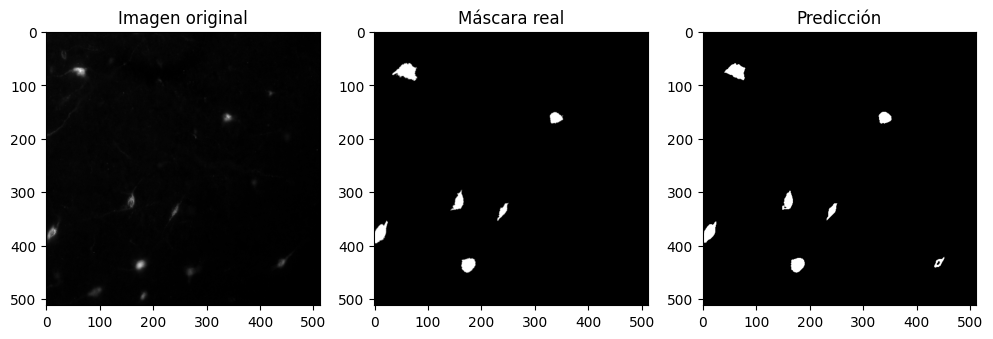

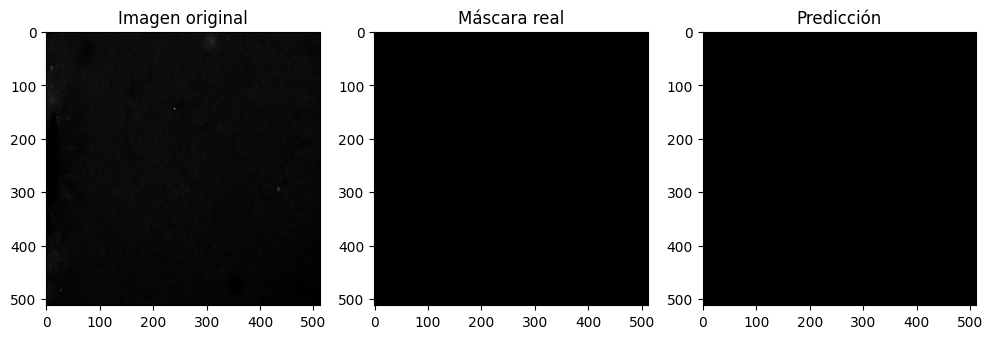

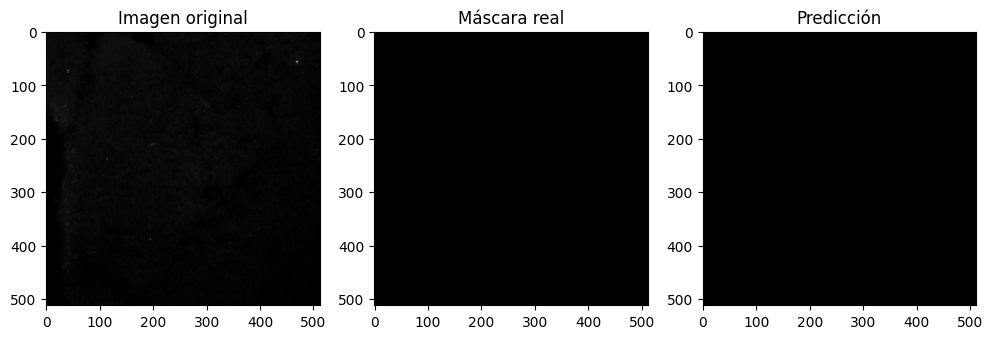

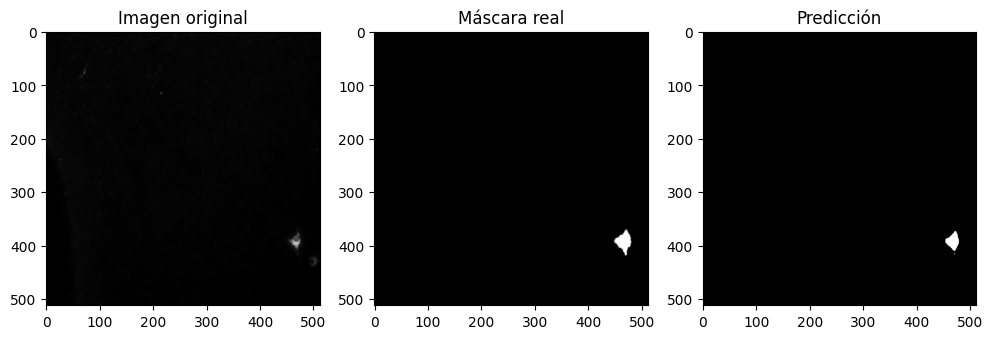

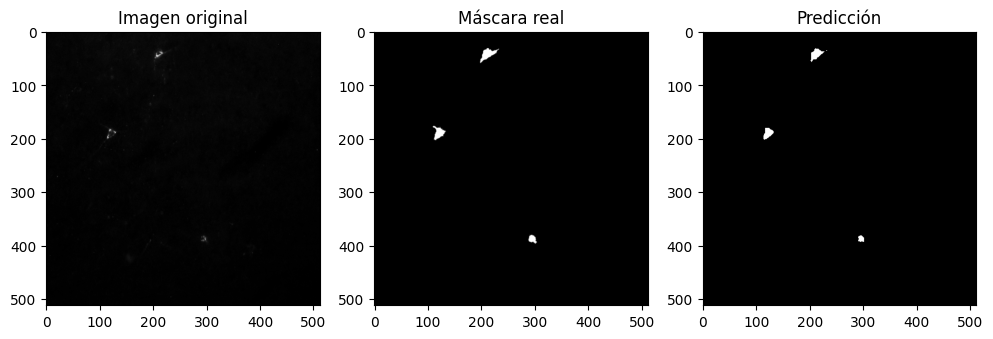

In [5]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            # Mostrar imágenes originales, máscaras reales y predicciones
            for j in range(len(images)):
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(images[j].cpu().squeeze(), cmap='gray')
                axes[0].set_title('Imagen original')
                axes[1].imshow(masks[j].cpu().squeeze(), cmap='gray')
                axes[1].set_title('Máscara real')
                axes[2].imshow(predictions[j].cpu().squeeze(), cmap='gray')
                axes[2].set_title('Predicción')

                plt.show()

# Visualizar algunas predicciones
visualize_predictions(model, val_loader)
